In [1]:
# install kaggle package
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# copy kaggle account file 
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:20<00:00, 141MB/s]
100% 2.70G/2.70G [00:20<00:00, 138MB/s]


In [4]:
# unzip dataset
!mkdir Dataset
!unzip /content/new-plant-diseases-dataset.zip -d /content/Dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/Dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2

In [6]:
# in colab unzip data is gettting duplicated so removing it
!rm -r '/content/Dataset/new plant diseases dataset(augmented)'

In [1]:
import os
import shutil
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd

In [2]:
# initialize seaborn figure
sns.set(rc={'figure.figsize':(11,5)})

### CustomModel

In [3]:
# initialzie batch size and image size
BATCH_SIZE = 64
IMG_SIZE = [128, 128]

In [4]:
# import keras modules
from keras.utils import image_dataset_from_directory
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout, Rescaling
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

In [5]:
# train set and validation set paths
train_path = 'Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_path = 'Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [11]:
# initialize keras datagen and also scale down pixels
# augmentation is included
# splitting train set in to 80:20 where 20% is test set
#
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  zoom_range=0.3,
                                   shear_range=0.2,
                                   validation_split=0.2)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_data = datagen_train.flow_from_directory(train_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                          seed=1,
                                          subset='training')

test_data = datagen_train.flow_from_directory(valid_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE,
                                        seed=1,
                                        subset='validation')

valid_data = datagen_valid.flow_from_directory(valid_path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE)

Found 56251 images belonging to 38 classes.
Found 3503 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [12]:
# defining model layers
inputs = Input((IMG_SIZE + [3]))
s = inputs
# adding layers
l1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
l1 = Dropout(0.1)(l1)
l1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l1)
p1 = MaxPooling2D((2, 2))(l1)

l2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
l2 = Dropout(0.1)(l2)
l2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l2)
p2 = MaxPooling2D((2, 2))(l2)

l3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
l3 = Dropout(0.2)(l3)
l3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l3)
p3 = MaxPooling2D((2, 2))(l3)

l4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
l4 = Dropout(0.2)(l4)
l4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l4)
p4 = MaxPooling2D(pool_size=(2, 2))(l4)

l5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
l5 = Dropout(0.3)(l5)
l5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(l5)

# flattening dimension to 1
l6 = Flatten()(l5)
l6 = Dense(512, activation='relu')(l6)
l6 = Dropout(0.5)(l6)

# classification layer
outputs = Dense(38, activation='softmax')(l6)

# concating input layers with output/classification layer
model = Model(inputs=[inputs], outputs=[outputs])

In [13]:
# Set callback functions to  save the best model so far
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                             

In [15]:
# train model
model.fit(train_data,
          batch_size=64,
          validation_data=valid_data,
          callbacks=callbacks,
          epochs = 40)

Epoch 1/40
879/879 [==============================] - 327s 366ms/step - loss: 2.6211 - accuracy: 0.2646 - val_loss: 2.0209 - val_accuracy: 0.4604
Epoch 2/40
879/879 [==============================] - 153s 174ms/step - loss: 1.3043 - accuracy: 0.5999 - val_loss: 1.8410 - val_accuracy: 0.5061
Epoch 3/40
879/879 [==============================] - 221s 251ms/step - loss: 0.8016 - accuracy: 0.7524 - val_loss: 1.1598 - val_accuracy: 0.6710
Epoch 4/40
879/879 [==============================] - 239s 272ms/step - loss: 0.5566 - accuracy: 0.8272 - val_loss: 0.8524 - val_accuracy: 0.7450
Epoch 5/40
879/879 [==============================] - 147s 167ms/step - loss: 0.4305 - accuracy: 0.8650 - val_loss: 0.7535 - val_accuracy: 0.7728
Epoch 6/40
879/879 [==============================] - 147s 167ms/step - loss: 0.3474 - accuracy: 0.8911 - val_loss: 1.0269 - val_accuracy: 0.7283
Epoch 7/40
879/879 [==============================] - 149s 169ms/step - loss: 0.3002 - accuracy: 0.9054 - val_loss: 0.3711 -

In [17]:
# model.save('model2.h5')

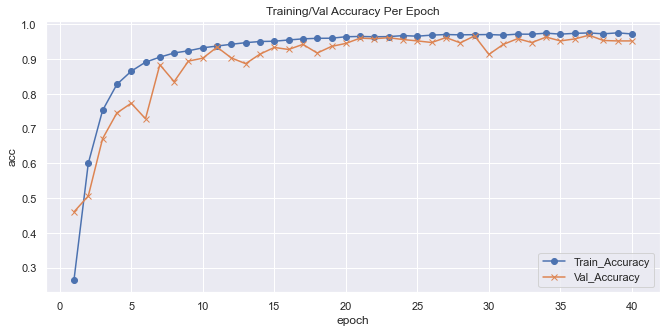

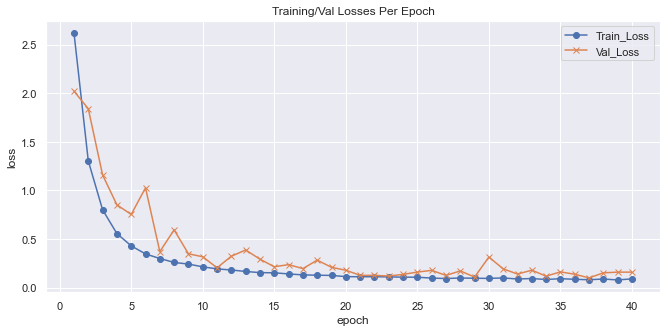

In [16]:
# plotting loss graphs w.r.t each epoch
f, ax = plt.subplots()
ax.plot([None] + model.history.history["accuracy"], 'o-')
ax.plot([None] + model.history.history["val_accuracy"], 'x-')

ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
ax.set_title('Training/Val Accuracy Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
plt.show()

f, ax = plt.subplots()
ax.plot([None] + model.history.history["loss"], 'o-')
ax.plot([None] + model.history.history["val_loss"], 'x-')

ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
ax.set_title('Training/Val Losses Per Epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

### Evaluation

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import classification_report

In [18]:
# this function will evaluate trained model on validation set
def report(prediction, y_true):
    print('        ----------Classification Report Of Classes-------------')
    print(classification_report(y_true,prediction,target_names=label_names))
    print('\n        ----------Validation Data------------------')
    print('Accuarcy:',accuracy_score(y_true, prediction)* 100)
    print('Precision: {:,.2f} %'.format(precision_score(y_true, prediction, average='weighted') * 100))
    print('Recall-score: {:,.2f}'.format(recall_score(y_true, prediction, average='weighted') * 100))
    print('F1-score: {:,.2f}'.format(f1_score(y_true, prediction, average='weighted') * 100))
    cm = confusion_matrix(y_true,prediction)
    print('\n-----------Confusion Matrix------------\n')
    print(cm)
    
    plt.figure(figsize=(17,15))
    plt.imshow(cm , cmap= plt.cm.Blues_r)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks,label_names, rotation = 90)
    plt.yticks(tick_marks,label_names)
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j],'.2f'), ha='center', va='center',
                     color='black' if cm[i,j] > thresh else 'white')
    plt.show()

In [19]:
# we need label encoder of labels so getting it from saved file
import joblib
label_le = joblib.load('labels.pkl')

In [20]:
# extracting images and labels from keras datagen of valid set
valid_img = []
valid_label = []
batch_index = 0

while batch_index <= valid_data.batch_index:
    data = valid_data.next()
    valid_img.extend(data[0])
    valid_label.extend(np.argmax(data[1], axis=1))
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
valid_img = np.asarray(valid_img)

In [21]:
# load best saved model
from keras.models import load_model
best_model = load_model('best_model.h5')

550/550 [==============================] - 4s 6ms/step
        ----------Classification Report Of Classes-------------
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.95      0.97       504
                                 Apple___Black_rot       0.97      1.00      0.98       497
                          Apple___Cedar_apple_rust       0.96      0.99      0.98       440
                                   Apple___healthy       0.95      0.95      0.95       502
                               Blueberry___healthy       0.93      0.99      0.96       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.98      0.98       421
                 Cherry_(including_sour)___healthy       0.98      0.97      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.91      0.93       410
                       Corn_(maize)___Common_rust_  

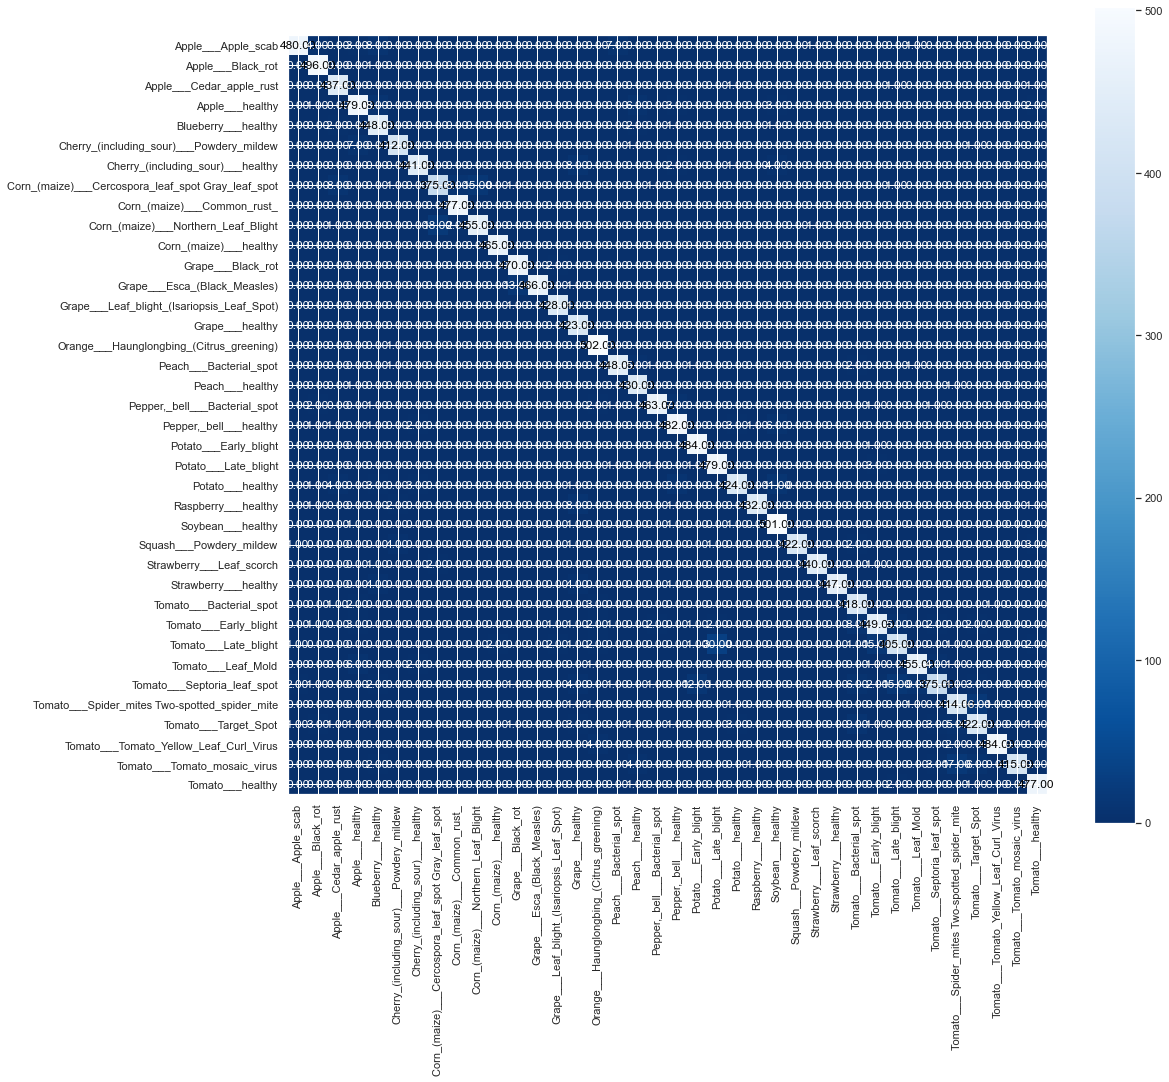

In [22]:
# predicting results of valid set from best model and evaluating the prediction

label_names = label_le.classes_
prediction = best_model.predict(valid_img)
prediction = np.argmax(prediction,axis=1)
report(prediction, valid_label)

### Post model Analysis

In [30]:
false_pred, false_label, true_label = list(), list(), list()
for e,img in enumerate(valid_img):
    img = np.expand_dims(img, axis=0)
    predict = best_model.predict(img, verbose=0)
    predict = np.argmax(predict,axis=1)
#     predict = label_le.inverse_transform(predict)
    if predict[0] != valid_label[e]:
        false_pred.append(np.squeeze(img))
        false_label.extend(label_le.inverse_transform(predict))
        true_label.extend(label_le.inverse_transform([valid_label[e]]))

In [31]:
print('Total False Predictions are:', len(false_label))

Total False Predictions are: 552


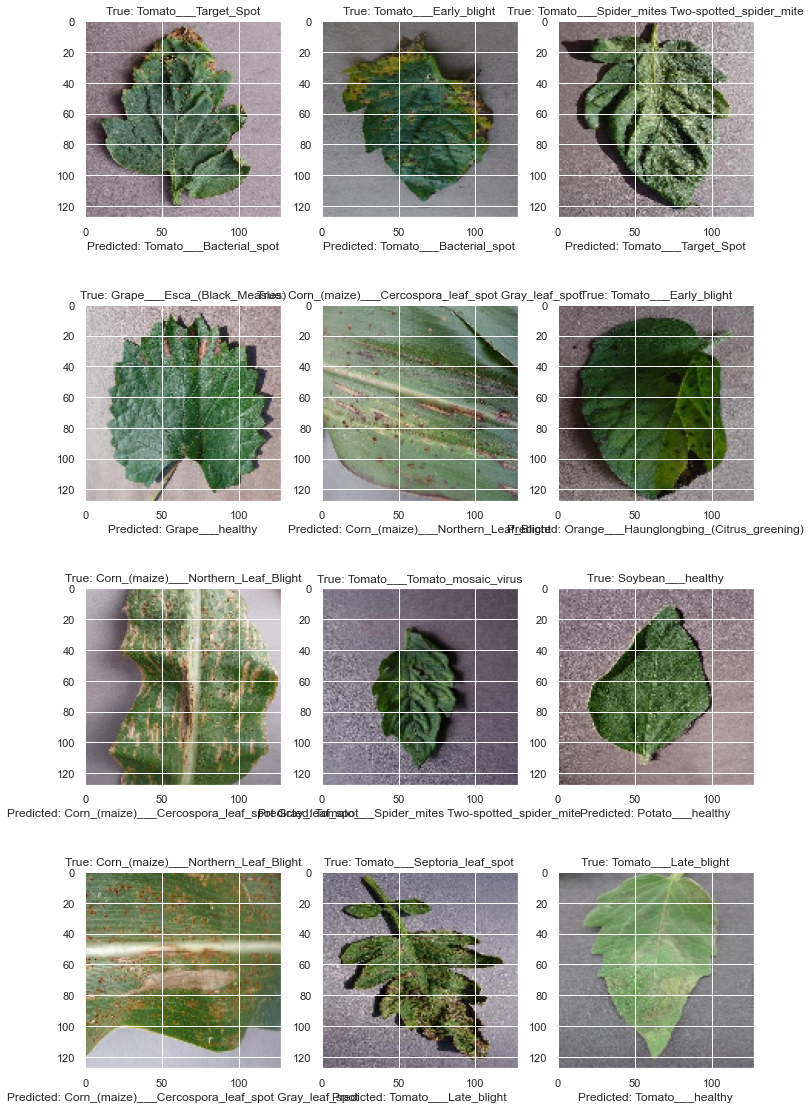

In [64]:
row, col = 4,3
plt.figure(figsize=(12,20))

for elem in range(row*col):
    plt.subplot(row, col, elem+1)
    idx = np.random.choice(len(false_pred))
    plt.imshow(false_pred[idx])
    plt.xlabel("Predicted: %s"%false_label[idx] )
    plt.title("True: %s"%true_label[idx])
plt.show()

In [65]:
del valid_img
del valid_label

### Test Set Evaluation

In [66]:
# extracting images and labels from keras datagen of test set
test_img = []
test_label = []
batch_index = 0

while batch_index <= test_data.batch_index:
    data = test_data.next()
    test_img.extend(data[0])
    test_label.extend(np.argmax(data[1], axis=1))
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
test_img = np.asarray(test_img)

110/110 [==============================] - 1s 8ms/step
        ----------Classification Report Of Classes-------------
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.92      0.95       100
                                 Apple___Black_rot       0.97      0.99      0.98        99
                          Apple___Cedar_apple_rust       0.91      0.98      0.94        88
                                   Apple___healthy       0.87      0.94      0.90       100
                               Blueberry___healthy       0.90      0.97      0.93        90
          Cherry_(including_sour)___Powdery_mildew       0.99      0.94      0.96        84
                 Cherry_(including_sour)___healthy       0.95      0.88      0.91        91
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.80      0.86        82
                       Corn_(maize)___Common_rust_  

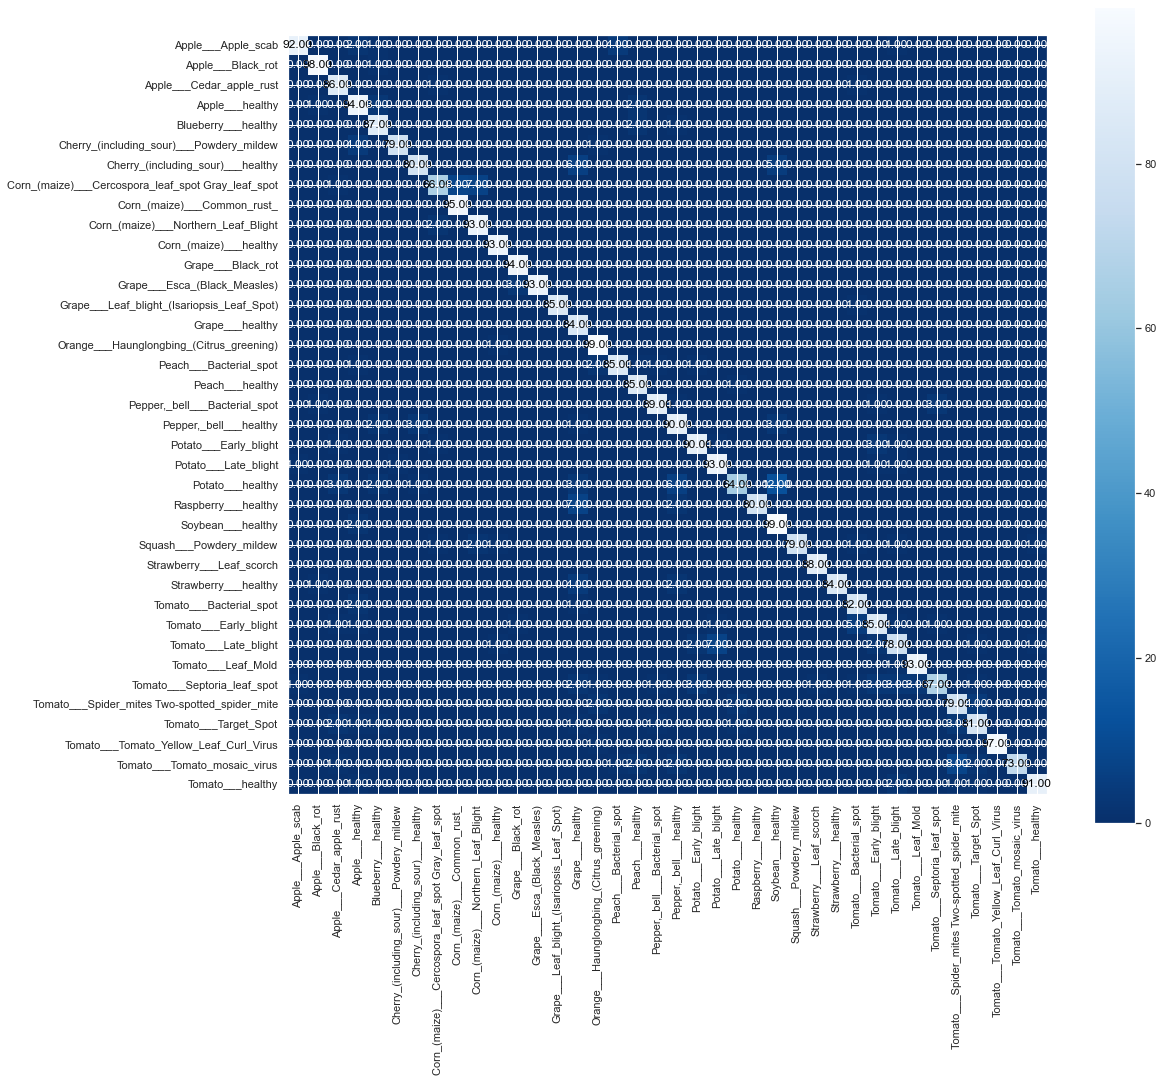

In [67]:
# predicting results of test set from best model and evaluating the prediction

label_names = label_le.classes_
prediction = best_model.predict(test_img)
prediction = np.argmax(prediction,axis=1)
report(prediction, test_label)

### ReaL-Time Prediction

In [68]:
# pass any image path with trained model and this function will predict the result
def predict_image(img_path, model):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(image, (int(128), int(128)))
    img = img/255.
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    predict = np.argmax(predict,axis=1)
    predict = label_le.inverse_transform(predict)
    
    plt.figure(figsize=(6,8))
    plt.imshow(image)
    plt.xlabel(f'Predicted is: "{predict[0]}"')
    plt.show()

1/1 [==============================] - 0s 12ms/step


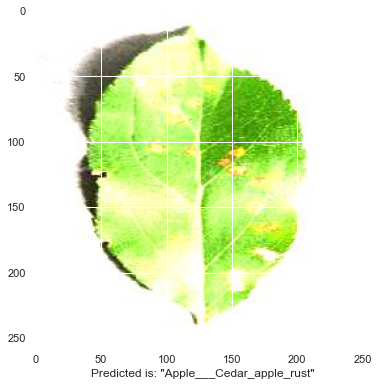

In [69]:
img_path = 'Dataset/test/test/AppleCedarRust1.JPG'
predict_image(img_path, best_model)

1/1 [==============================] - 0s 14ms/step


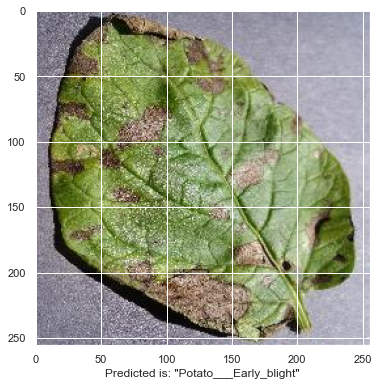

In [71]:
img_path = 'Dataset/test/test/PotatoEarlyBlight1.JPG'
predict_image(img_path, best_model)

1/1 [==============================] - 0s 11ms/step


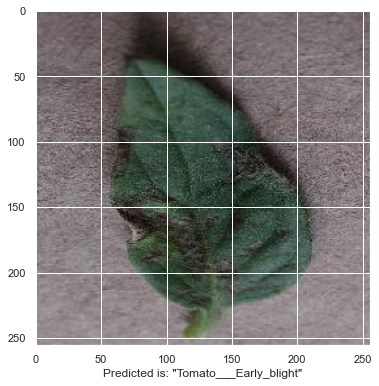

In [73]:
img_path = 'Dataset/test/test/TomatoEarlyBlight6.JPG'
predict_image(img_path, best_model)